<a href="https://colab.research.google.com/github/pwolscho/unet/blob/master/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![U-Net Demonstration](https://drive.google.com/uc?id=1-kEr1EjJgpSjGCV1oFfYw_A2cnu5cNVI)

#Über dieses Notebook

U-Net ist die bekannteste Architektur im Bereich der Semantischen Segmentierung (Anwendung: Segmentierung in Bildern). Im Rahmen des Kurses Seminat-Deep-Learning der Hochschule Offenburg zeigt dieses Notebook eine mögliche Implementierung von U-Net und demonstriert dessen Anwendung anhand eines Beispiel-Datensatzes.

##Informationen zum Datensatz

Mehrere Gebiete der Erde mit großen Öl- und Gasansammlungen haben auch riesige Salzlagerstätten unter der Oberfläche, d.h. dort wo Salz ist, wird vermutlich auch das wertvolle Öl zu finden sein.

Professionelle seismische Messungen zum Auffinden der Salzlagerstätten erfordert immer noch eine fachkundige menschliche Interpretation der daraus resultierenden Bilddaten. Dies führt zu sehr subjektiven, sehr variablen Ergebnissen. Das führt zu potenziell gefährlichen Situationen für Bohrer von Öl- und Gasunternehmen.

Um sehr präzise seismischen Bilder zu erstellen, hofft TGS-NOPEC Geophysical Systems (das weltweit führende Unternehmen für geophysikalische Dienste), dass die Online-Community von Kaggle in der Lage sein wird, einen Algorithmus zu entwickeln, der automatisch und genau erkennt, ob und Salz unter der Erdoberfläche zu finden ist oder nicht.

Dazu wurde im Jahr 2018 eine Wettbewerb von Kaggle durchgeführt.

Auf den diesem Notebook verwendete Datensatz kann nach wie vor unter https://www.kaggle.com/c/tgs-salt-identification-challenge/data  zugegriffen werden.

Die Daten sind eine Reihe von seismischen Bildern von zufällig ausgewählten Orten der Erde. Die Bilder sind 101 x 101 Pixel groß und jedes Pixel wird entweder als Salz oder als Sediment klassifiziert. Zusätzlich zu den seismischen Bildern wird für jedes Bild die Tiefe der aufgenommenen Position angegeben.

##Gliederung des Notebooks

Die durchgeführten Schritte gliedern sich chronologisch wie folgt:

- Vorbereitende Maßnahmen
  - Einbinden benötigter Bibliotheken
  - Setzen von globalen Einstellungen
  - Bereitstellung des Datensatzes
  - Anzeigen der Bilddaten
  - Darstellung der Tiefenverteilung der Trainigsdaten 
  - Darstellung des Verhältnisses von Salz und Tiefe der Trainigsdaten
  - Definition eines U-Net Algorithmus
- Training des Netzwerkes
- Evaluierung des Modells

#I. Vorbereitende Maßnahmen

##I.1 Einbinden benötigter Bibliotheken

In [1]:
#Installation ist vermutlich überflüssig
!pip install imageio #Lesen und Schreiben von Bilddaten
!pip install torch #Deep-Learning Bibliothek
!pip install kaggle #Zugriff auf den Datensatz von Kaggle
!pip install ipywidgets #Besondere grafische Schnittstellen

In [0]:
#Einbinden der Bibliotheken
import os
import imageio
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils import data
from google.colab import drive
from google.colab import files
from zipfile import ZipFile


##Setzen globaler Einstellungen

In [0]:
#Anzeigen von Plots direkt unter der Plot-generierenden Zelle
%matplotlib inline

##Bereitstellung des Datensatzes

###Zugriff auf die Kaggle-API vorbereiten

Um auf den Datensatz von Kaggle zugreifen zu können, wird die Kaggle-API (https://www.kaggle.com/docs/api) und einen persönlichen API-Token benötigt. Der API-Token kann im persönlichen Account von Kaggle generiert werden. Um den manuellen Upload (files.upload()) zu umgehen wird der Inhalt des Tokens hartkodiert.

In [0]:
kaggle_json = '{"username":"philipwolschon","key":"715ad801ca6728d6730b7c276db32c6f"}'

Zunächst wird die leere Datei kaggle.json angelegt und mit dem Inhalt des kaggle_json-Objekts (API-Token) befüllt.

In [0]:
with open('kaggle.json', 'w') as file:
  json.dump(kaggle_json, file, ensure_ascii=False)

In [0]:
with open('kaggle.json', 'w') as file:
  file.write(kaggle_json)

Außerdem erwartet die Kaggle-API, dass der API-Token in ~/.kaggle/ (/root/.kaggle/) zu finden ist.

In [0]:
!mkdir -p ~/.kaggle #Den Ordner anlegen
!mv kaggle.json ~/.kaggle/ #Den API-Token verschieben

Liefert folgende Funktion True zurück wurde die erforderliche Datei im korrekten Verzeichnis der VM erstellt.

In [8]:
os.path.isfile("/root/.kaggle/kaggle.json")

True

Um Warnungen beim Starten von Kaggle-Tools zu vermeiden werdem dem Besitzer der Datei Lese- und Schreibrechte gewährt.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

###Download und Entpacken des Datensatzes

Mit Hilfe der Kaggle-API kann nun das Datenset heruntergeladen werden.

In [10]:
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/salt_data 

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 44.0MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 80.2MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 61.7MB/s]
 94% 153M/163M [00:01<00:00, 127MB/s]
100% 163M/163M [00:01<00:00, 138MB/s]
 76% 29.0M/37.9M [00:00<00:00, 34.4MB/s]
100% 37.9M/37.9M [00:00<00:00, 64.6MB/s]


Die Trainigs- und Testdaten sind komprimiert und müssen zunächst entpackt werden.

In [0]:
#Entpacken der Testdaten
with ZipFile('/content/salt_data/test.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/test')
#Entpacken der Trainingsdaten
with ZipFile('/content/salt_data/train.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/train')

##Sichtung des Datensatzes

In [0]:
train_mask = pd.read_csv('/content/salt_data/train.csv')
depth = pd.read_csv('/content/salt_data/depths.csv')

In [25]:
train_mask.head(5)

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [26]:
depth.head(5)

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


###Klassen- und Methodendefinition

Die Klasse SaltDataset repräsentiert den Datensatz und soll einen einfachen Zugriff auf die Bilddaten ermöglichen.

In [0]:
class SaltDataset(data.Dataset):

  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, index):
    file_id = self.file_list[index]

    #root path + image folder + image
    image_folder = os.path.join(self.root_path, 'images')
    image_path = os.path.join(image_folder, file_id + '.png')

    #root path + mask folder + image
    mask_folder = os.path.join(self.root_path, 'masks')
    mask_path = os.path.join(mask_folder, file_id + '.png')

    #convert image to numpy array
    image = np.array(imageio.imread(image_path), dtype = np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype = np.uint8)

    return image, mask
  

Die nachfolgende Funktion soll eine einfache Ausgabe der Bilddaten (Original und Maske) ermöglichen.

In [0]:
#function to visualize the images
def plotImageAndMask(image, mask):
  #invoke matplotlib
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')

###Initialisierung der SaltDataset-Klasse

In [0]:


train_path = '/content/salt_data/train'

file_list = list(train_mask['id'].values)
dataset= SaltDataset(train_path, file_list)

###Ausgabe der Trainingsbilder mit Maske

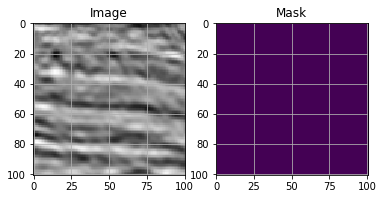

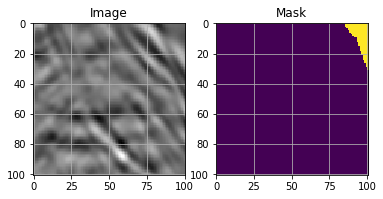

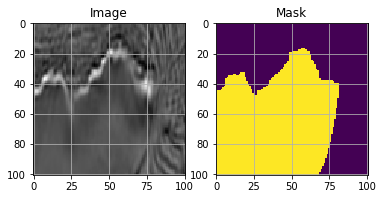

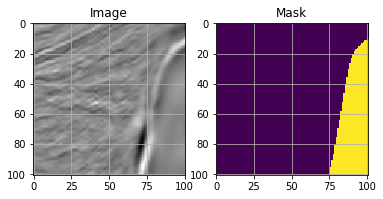

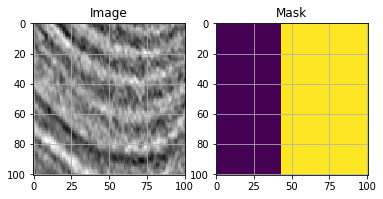

In [15]:
#print the images
for i in range(5):
  image, mask = dataset[np.random.randint(0, len(dataset))]
  plotImageAndMask(image, mask)

###Ausgabe des Features Tiefe

Rein informativ folgt eine grafische Darstellung einer Häufigkeitsverteilung der Tiefe des Salzes.

Text(0.5, 1.0, 'depth distribution')

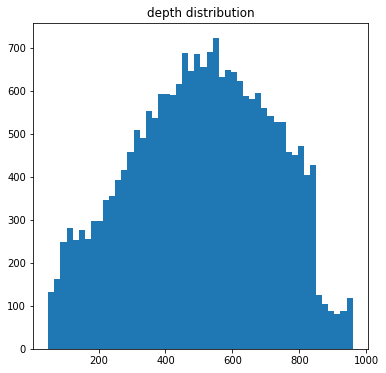

In [17]:
#plot the distribution of depths
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('depth distribution')

In [0]:
#convert run length encoding to images that can be input into our model
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [0]:
#function for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [0]:
#prepare to merge depth
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101, 101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [21]:
#merge it
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5, 1.0, 'proportion of salt vs depth')

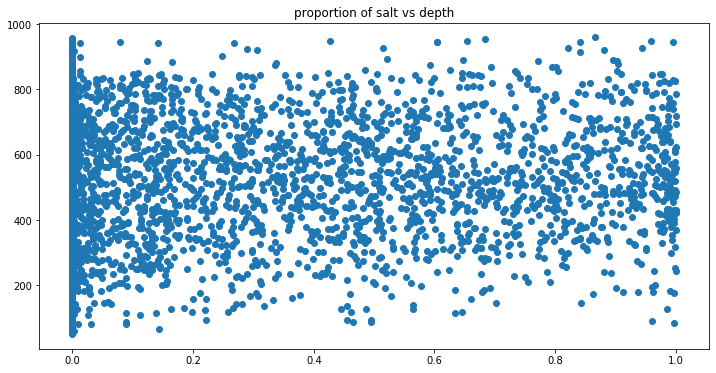

In [23]:
#show proportion of salt vs depth
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('proportion of salt vs depth')

#II. Training des Netzwerkes

##Vorbereitung

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from __future__ import absolute_import, division, print_function, unicode_literals
from keras import backend as K

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [0]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]            

In [0]:
!pip install ipywidgets

In [0]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path + "images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

StopIteration: ignored

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

##Training

In [0]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))




Train on 3400 samples, validate on 600 samples
Epoch 1/50





3400/3400 [==============================] - 28s 8ms/step - loss: 0.5303 - val_loss: 0.4380

Epoch 00001: val_loss improved from inf to 0.43797, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.4570 - val_loss: 0.4262

Epoch 00002: val_loss improved from 0.43797 to 0.42623, saving model to model-tgs-salt-1.h5
Epoch 3/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.4136 - val_loss: 0.3579

Epoch 00003: val_loss improved from 0.42623 to 0.35789, saving model to model-tgs-salt-1.h5
Epoch 4/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.3607 - val_loss: 0.3287

Epoch 00004: val_loss improved from 0.35789 to 0.32873, saving model to model-tgs-salt-1.h5
Epoch 5/50
3400/3400 [==============================] - 14s 4ms/step - loss: 0.3062 - val_loss: 0.2621

Epoch 00005: val_loss improved from 0.32873 to 0.26208, savin

KeyboardInterrupt: ignored

#III. Evaluierung des Modells